In [1]:
import pandas as pd
import math
import networkx as net
from networkx.algorithms import bipartite as bi
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pth = r"C:\Users\scohendevries\Documents\DATA620"
upth = r"\BX-Users.csv"
bpth = r"\BX-Books.csv"
rpth = r"\BX-Book-Ratings.csv"

usersDF = pd.read_csv(pth + upth, sep=";", encoding = "ISO-8859-1")
booksDF = pd.read_csv(pth + bpth, sep=";", encoding = "ISO-8859-1", error_bad_lines=False)
reviews = pd.read_csv(pth + rpth, sep=";", encoding = "ISO-8859-1")

b'Skipping line 43667: expected 8 fields, saw 10\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 10\nSkipping line 261529: expected 8 fields, saw 9\n'
C:\Users\scohendevries\AppData\Local\Continuum\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
usersDF.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [4]:
booksDF.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton&Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [36]:
reviews = pd.merge(pd.merge(reviews,usersDF,how='inner',on='User-ID'),booksDF,how='inner',on='ISBN')[
    ['User-ID','ISBN','Location','Age','Book-Title','Book-Author']
]
reviews.head()

,User-ID,ISBN,Location,Age,Book-Title,Book-Author
0,276725,034545104X,"tyler, texas, usa",NaN,Flesh Tones: A Novel,M. J. Rose
1,276726,0155061224,"seattle, washington, usa",NaN,Rites of Passage,Judith Rae
2,276727,0446520802,"h, new south wales, australia",16.0,The Notebook,Nicholas Sparks
3,278418,0446520802,"omaha, nebraska, usa",NaN,The Notebook,Nicholas Sparks
4,276729,052165615X,"rijeka, n_a, croatia",16.0,Help!: Level 1,Philip Prowse


In [60]:
reviews = reviews.head(10000)
users = reviews['User-ID'].values.tolist()
books = reviews['ISBN'].values.tolist()

g=net.from_pandas_edgelist(reviews,'User-ID','ISBN',['Location','Age','Book-Title','Book-Author'])#,'Book-Rating')

print(len(g))

8874


In [61]:
uNet = bi.weighted_projected_graph(g, users)

In [62]:
bkNet = bi.weighted_projected_graph(g, books)

In [9]:
for i in sorted(net.connected_components(uNet), key = len, reverse=True)[0:20]:
    print(len(i))

300
4
3
3
3
3
2
2
2
2
2
2
2
2
2
1
1
1
1
1


In [10]:
for i in sorted(net.connected_components(bkNet), key = len, reverse=True)[0:20]:
    print(len(i))

7839
136
82
42
42
26
26
25
22
20
19
19
18
14
12
12
12
12
12
11


In [63]:
#only taking the top connected component
uNet = max(net.connected_component_subgraphs(uNet), key=len)

In [12]:
def trim_edges(g, weight=1):
    g2=net.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,weight=edata['weight'])
    return g2

def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

def sorted_map(d):
    ms = sorted(d.items(), key=lambda x: x[1], reverse=True)
    return ms

C:\Users\scohendevries\AppData\Local\Continuum\miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


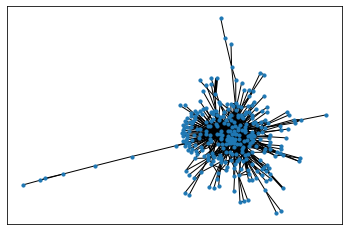

In [13]:
uweights=[edata['weight'] for f,t,edata in uNet.edges(data=True)]
net.draw_networkx(uNet,width=uweights, node_size=10, with_labels=False)

(array([806.,  11.,   5.,   1.,   1.,   1.,   0.,   0.,   0.,   2.]),
 array([ 1. ,  3.1,  5.2,  7.3,  9.4, 11.5, 13.6, 15.7, 17.8, 19.9, 22. ]),
 <a list of 10 Patch objects>)

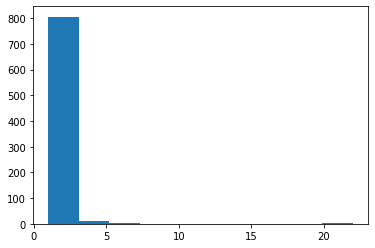

In [41]:
plt.hist(uweights)

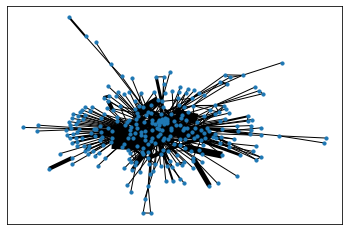

In [64]:
unet_trim=trim_edges(uNet, weight=0.4)
weights=[edata['weight'] for f,t,edata in unet_trim.edges(data=True)]
net.draw_networkx(unet_trim,width=uweights, node_size=10, with_labels=False)

In [44]:
bkweights=[edata['weight'] for f,t,edata in bkNet.edges(data=True)]
#net.draw_networkx(bkNet,width=bkweights, edge_color=bkweights, with_labels=False)

(array([8.221389e+06, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 8.440000e+02, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 7.000000e+00]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

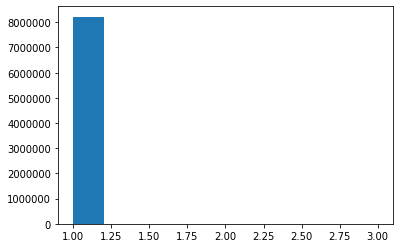

In [45]:
plt.hist(bkweights)

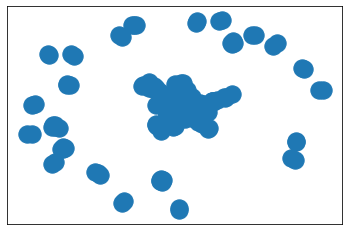

In [65]:
bknet_trim=trim_edges(bkNet, weight=1)
bkweights=[edata['weight'] for f,t,edata in bknet_trim.edges(data=True)]
#edge_labels=dict([((u,v,),d['weight']) for u,v,d in bknet_trim.edges(data=True)])
net.draw_networkx(bknet_trim,width=1, edge_color=bkweights, with_labels=False)#True, labels=edge_labels)

In [22]:
btwn = net.betweenness_centrality(bknet_trim)
top_books = []
for i in sorted_map(btwn)[:10]:
    top_books.append(i[0])
booksDF[booksDF['ISBN'].isin(top_books)][['ISBN','Book-Title','Book-Author']]

,ISBN,Book-Title,Book-Author
26,0971880107,Wild Animus,Rich Shapero
52,0440225701,The Street Lawyer,JOHN GRISHAM
408,0316666343,The Lovely Bones: A Novel,Alice Sebold
1640,0380600129,The Indian in the Cupboard,Lynne Reid Banks
1680,0440226430,Summer Sisters,Judy Blume
2379,0425175405,Black Notice,Patricia Daniels Cornwell
2433,0553579754,Fear Nothing,DEAN KOONTZ
2866,0446611212,Violets Are Blue,James Patterson
4057,0425116840,The Cardinal of the Kremlin (Jack Ryan Novels),Tom Clancy
4173,0553582755,One Door Away from Heaven,Dean R. Koontz


In [20]:
btwn = net.betweenness_centrality(unet_trim)
top_users = []
for i in sorted_map(btwn)[:25]:
    top_users.append(i[0])
usersDF[usersDF['User-ID'].isin(top_users)]

,User-ID,Location,Age
242,243,"arden hills, minnesota, usa",NaN
276847,276848,"köln, nordrhein-westfalen, germany",41.0
276924,276925,"barcelona, barcelona, spain",22.0
276935,276936,"kitzbuehel, tirol, austria",32.0
277194,277195,"san francisco, california, usa",54.0
277377,277378,"vancouver, british columbia, canada",33.0
277426,277427,"gilbert, arizona, usa",48.0
277477,277478,"schiedam, zuid-holland, netherlands",31.0
277522,277523,"woodstock, virginia, usa",62.0
277638,277639,"forsyth, montana, usa",48.0


In [21]:
revDF = reviews[['ISBN','User-ID']].groupby('ISBN').agg(len)
revDF[revDF['User-ID']>1]

,User-ID
ISBN,
0020532105,2
002542730X,3
0028604199,2
0060096195,2
0060173289,4
...,...
360893541X,2
3608935428,2
3608935436,2


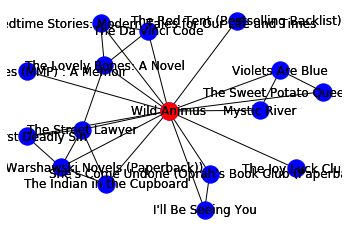

In [77]:
bk_ego = net.ego_graph(bknet_trim, '0971880107')

bk_attr = booksDF.set_index('ISBN').to_dict('index')
net.set_node_attributes(bk_ego,bk_attr)

pos = net.spring_layout(bk_ego)
node_labels = net.get_node_attributes(bk_ego,'Book-Title')
net.draw_networkx_labels(bk_ego, pos, labels = node_labels)

options = {"node_size": 300, "node_color": "r"}
net.draw(bk_ego, pos, node_color="b", node_size=300, with_labels=True, labels = node_labels)
net.draw_networkx_nodes(bk_ego, pos, nodelist=['0971880107'], **options)

plt.show()

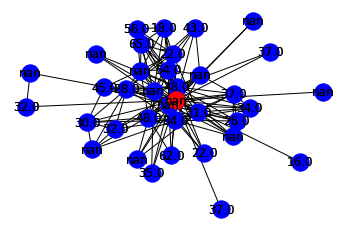

In [76]:
user_ego = net.ego_graph(unet_trim, 243)

user_attr = usersDF.set_index('User-ID').to_dict('index')
net.set_node_attributes(user_ego,user_attr)

pos = net.spring_layout(user_ego)
node_labels = net.get_node_attributes(user_ego,'Age')
net.draw_networkx_labels(user_ego, pos, labels = node_labels)

options = {"node_size": 300, "node_color": "r"}
net.draw(user_ego, pos, node_color="b", node_size=300, with_labels=True, labels = node_labels)
net.draw_networkx_nodes(user_ego, pos, nodelist=[243], **options)

plt.show()